# Make efficiency map plots for trained fitters

In [1]:
import train as tn
reload(tn)

import plotting
reload(plotting)

import util as ut

import matplotlib.pyplot as plt
#plt.style.use('seaborn-ticks')
plt.style.use('seaborn-poster')
%matplotlib inline
#%matplotlib notebook

import numpy as np

from pprint import pprint

import itertools

# import xgboost

Welcome to ROOTaaS 6.06/08


load the fitter:

In [2]:
path,name = "./classifiers", "effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out"
fitter = tn.IO.load(name,path,nodata=True)

./classifiers
./classifiers/effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out.pkl.gz
loading pickle ./classifiers/effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out.pkl.gz


In [3]:
def GetfeatureGrid (branches, projection) :
    feature_grid = []
    
    for bran in branches :
        if 'Pt' in bran :
            feature_grid.append((1,0.,300.))
        if 'Rapidity' in bran :
            feature_grid.append((1,0.,3.))
    
    for proj in projection :
        if 'Pt' in proj :
            feature_grid[branches.index(proj)] = (300,0.,300.)
        if 'Rapidity' in proj :
            feature_grid[branches.index(proj)] = (300,0.,3.)
    
    
    return feature_grid

In [33]:
branches = ['genJet2p5Pt0', 'genJet2p5Rapidity0', 'genJet2p5Pt1', 'genJet2p5Rapidity1', 'genJet2p5Pt2', 
            'genJet2p5Rapidity2', 'genJet2p5Pt3', 'genJet2p5Rapidity3', 'genPt', 'absGenRapidity']
projection = ['genJet2p5Pt0','genJet2p5Rapidity0']

GetfeatureGrid(branches,projection)

[(300, 0.0, 300.0),
 (300, 0.0, 3.0),
 (1, 0.0, 300.0),
 (1, 0.0, 3.0),
 (1, 0.0, 300.0),
 (1, 0.0, 3.0),
 (1, 0.0, 300.0),
 (1, 0.0, 3.0),
 (1, 0.0, 300.0),
 (1, 0.0, 3.0)]

In [20]:
def plot_efficiency_map_Njets (fitter,projection = ['genPt','absGenRapidity']):
    """
    This function is still in the developpment phase
    So far it is used to produce efficiency plots of Pt vs |y|
    : params 
            fitter : train.EffFitter - the trained classifier
         feedClass : boolean - has influence only on recoPtGrid which is never used
    """
    
    
    
    
    #generate 300 pt bins from 0-300 and 300 pseudo-rap bins from 0-3
    class_grid,class_eff_map = fitter.effMap('class',[(300,0,300),(300,0,3.)])
   

    branches = ['genJet2p5Pt0', 'genJet2p5Rapidity0', 'genJet2p5Pt1', 'genJet2p5Rapidity1', 'genJet2p5Pt2', 
            'genJet2p5Rapidity2', 'genJet2p5Pt3', 'genJet2p5Rapidity3', 'genPt', 'absGenRapidity']
    
    

    feature_grid = GetfeatureGrid(branches,projection)    
    axes = map(tn.mk_grid_1d,feature_grid)        
    feature_grid = np.array(list(itertools.product(*axes)))
    
    
    recoNjet2p5Grid =  np.hstack([feature_grid,class_eff_map]) if feedClass else class_grid
   
    
    recoNjets2p5_grid,recoNjets2p5_eff_map = fitter.effMap('recoNjets2p5',recoNjet2p5Grid)
    
    
    x_index = branches.index(projection[0])
    y_index = branches.index(projection[1])
    
    plotting.efficiency_map(recoNjets2p5_grid[:,x_index],recoNjets2p5_grid[:,y_index],recoNjets2p5_eff_map,
                            figsize=(14,26),xlabel=projection[0],ylabel=projection[1],
                        layout=(3,None))
    
    plt.subplots_adjust(hspace = 0.35, wspace = 0.4, top=0.88)




tab completion not implemented for this context

tab completion not implemented for this context


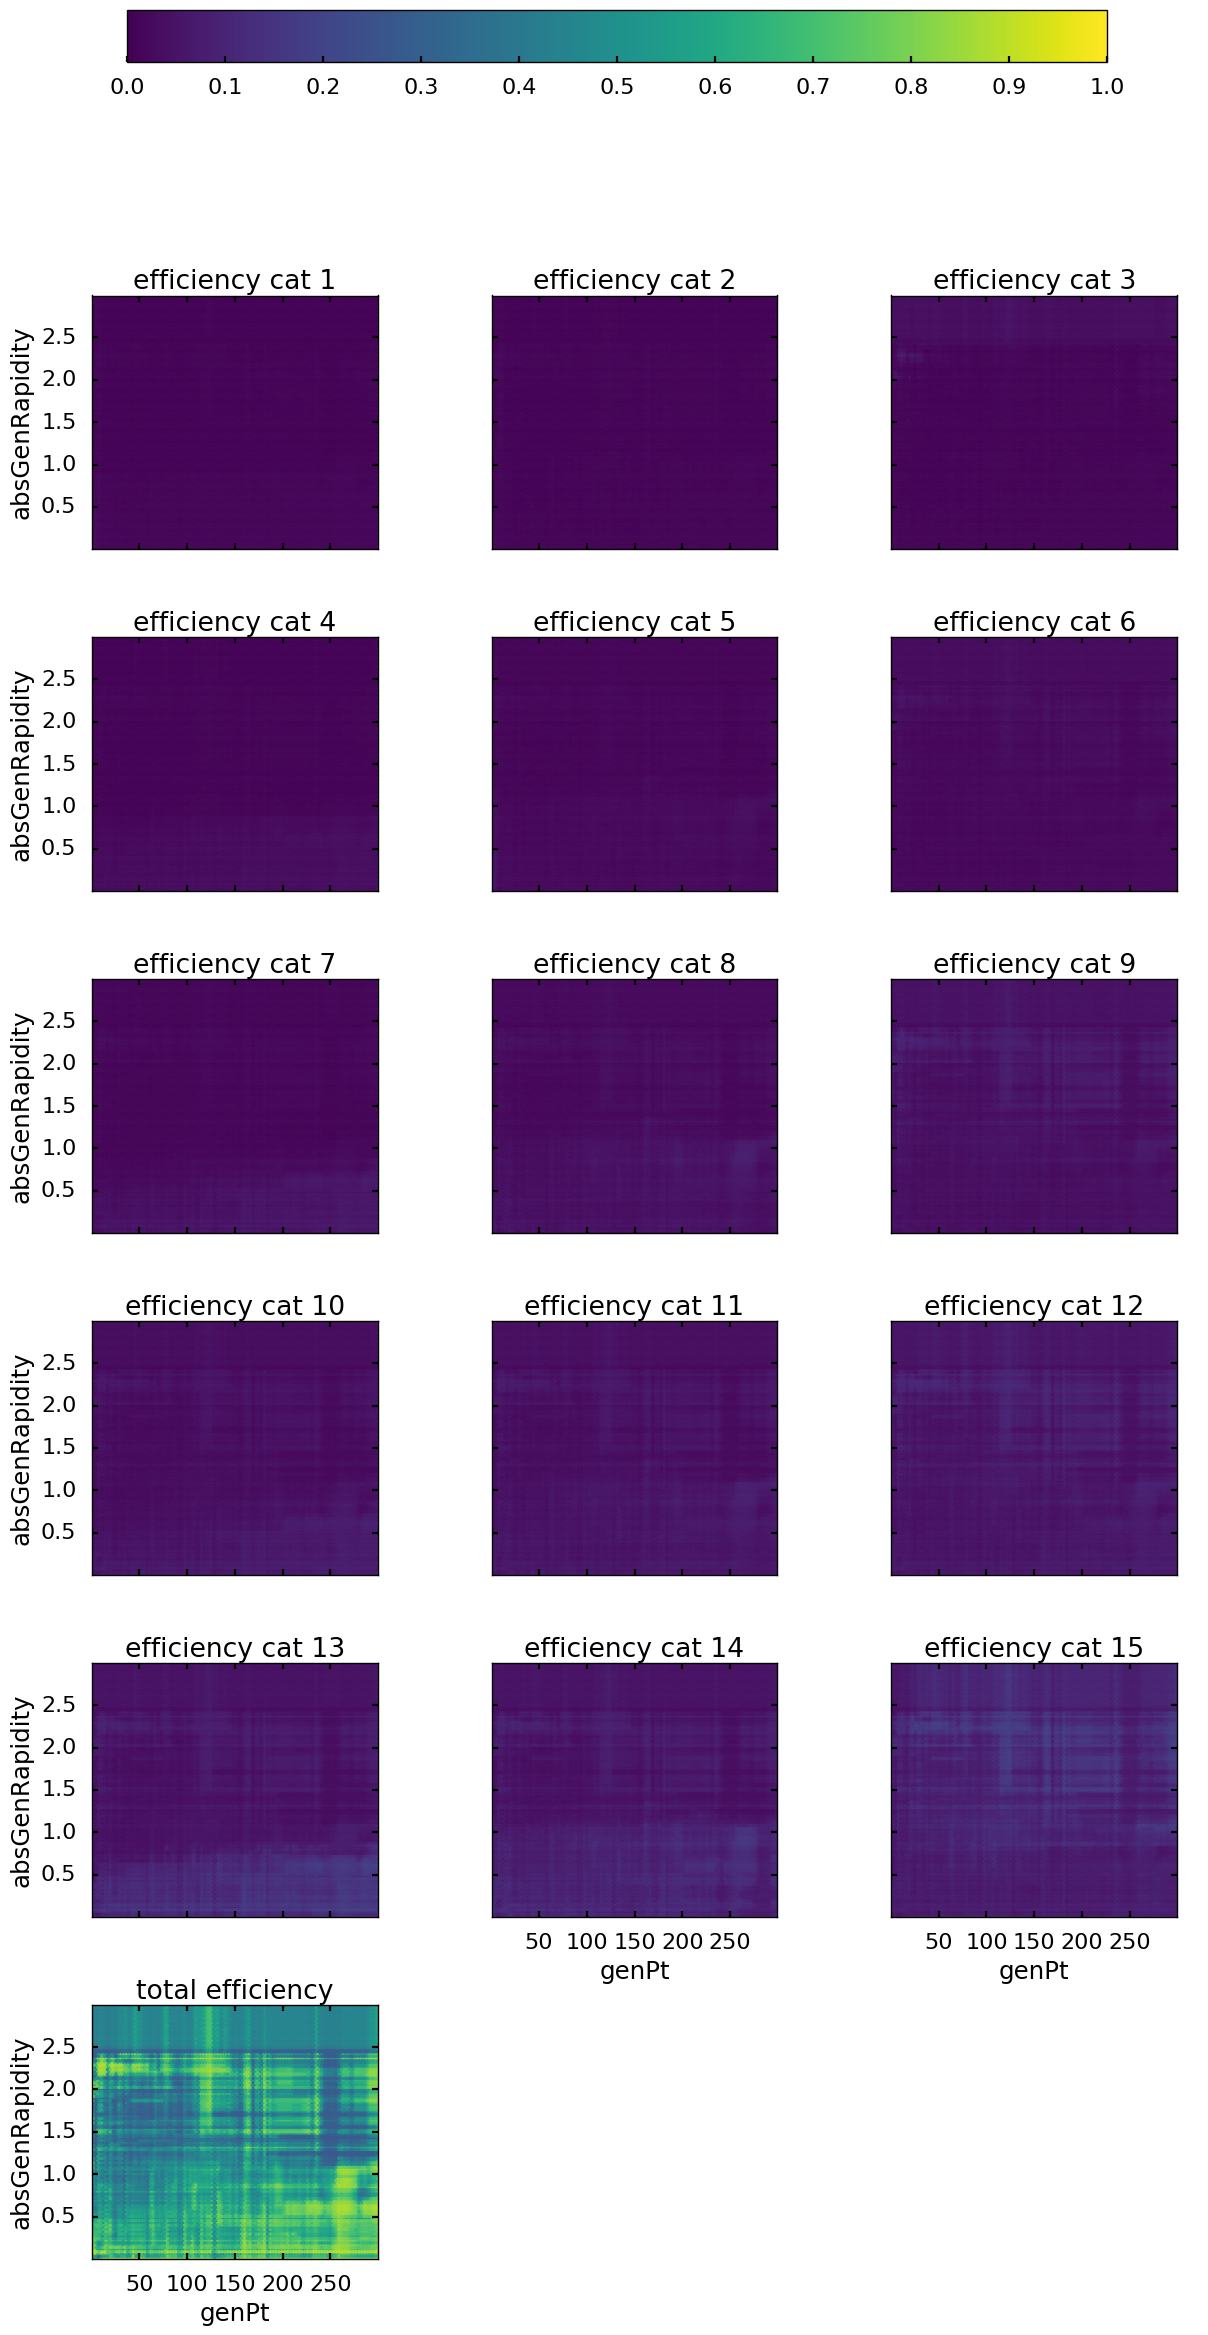

In [19]:
reload(plotting)
plot_efficiency_map_Njets(fitter)